<a href="https://colab.research.google.com/github/athenalobo/Music/blob/main/MaleVsFemale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install python_speech_features
!pip install hmmlearn
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
import itertools
import os

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=294de11cba79bf4bacf343458f6e0c46fb23efd679ce0cd27c18fe1c11482bcb
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
     |████████████████████████████████| 374 kB 5.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sampling_freq, audio = wavfile.read("/content/drive/MyDrive/Male-Female/Fem1.wav")

mfcc_features = mfcc(audio, sampling_freq)
filterbank_features = logfbank(audio, sampling_freq)

In [ ]:
print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 6001
Length of each feature = 13

Filter bank:
Number of windows = 6001
Length of each feature = 26


2
/content/drive/MyDrive/Male/train
/content/drive/MyDrive/Male/train/m/Copy of Mal4.wav 6004
/content/drive/MyDrive/Male/train
/content/drive/MyDrive/Male/train/f/Copy of Fem5.wav 6004


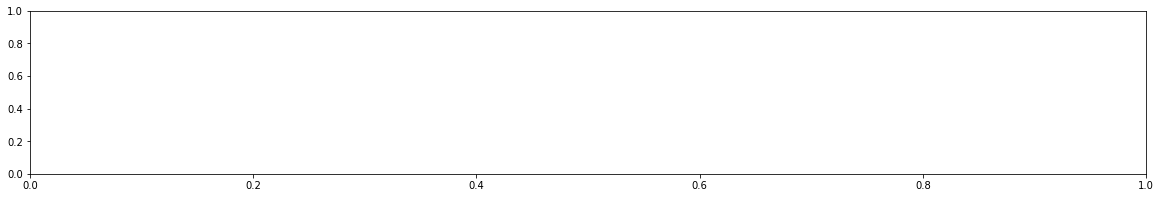

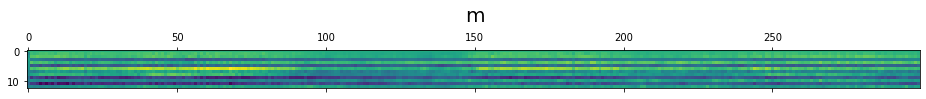

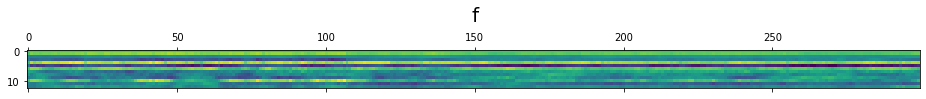

In [ ]:
import glob
import os.path as path
genre_list = ["m","f"]
print(len(genre_list))
figure = plt.figure(figsize=(20,3))
for idx ,genre in enumerate(genre_list): 
   example_data_path = '/content/drive/MyDrive/Male/train' 
   print(example_data_path)
   file_paths = glob.glob(path.join(example_data_path,genre, '*.wav'))
   sampling_freq, audio = wavfile.read(file_paths[0])
   mfcc_features = mfcc(audio, sampling_freq, nfft=1500)
   print(file_paths[0], mfcc_features.shape[0])
   plt.yscale('linear')
   plt.matshow((mfcc_features.T)[:,:300])
   plt.text(150, -10, genre, horizontalalignment='center', fontsize=20)
 
plt.yscale('linear')
plt.show()

In [ ]:
class Trainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []

        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,
                                         covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    # X is a 2D numpy array where each row is 13D
    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))

    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)


    

        
  

   

training hidden markov models (to do this we iterate over the songs in the subfolder in order to extract the features and append it to a variable.
We should store all trained HMM models, so we will be able to predict the class of unseen songs)

In [ ]:
    hmm_models = []
    input_folder = '/content/drive/MyDrive/Male/train'

    # Parse the input directory
    for dirname in os.listdir(input_folder):
        # Get the name of the subfolder
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder):
            continue

        # Extract the label
        label = subfolder[subfolder.rfind('/') + 1:]

        # Initialize variables
        X = np.array([])
        y_words = []

        # Iterate through the audio files (leaving 1 file for testing in each class)
        for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
            # Read the input file
            filepath = os.path.join(subfolder, filename)
            sampling_freq, audio = wavfile.read(filepath)

            # Extract MFCC features
            mfcc_features = mfcc(audio, sampling_freq)

            # Append to the variable X
            if len(X) == 0:
                X = mfcc_features
            else:
                X = np.append(X, mfcc_features, axis=0)

            # Append the label
            y_words.append(label)

        print('X.shape =', X.shape)
        # Train and save HMM model
        hmm_trainer = Trainer(n_components=10)
        hmm_trainer.train(X)
        hmm_models.append((hmm_trainer, label))
        hmm_trainer = None

X.shape = (234223, 13)


X.shape = (234079, 13)


Evaluating our models (to do this, we iterate over the test dataset subfolders and extract the features. Then we iterate through all HMM models and pick the one with the highest score)

In [ ]:
input_folder = '/content/drive/MyDrive/Male/test'
real_labels = []
pred_labels = []
for dirname in os.listdir(input_folder):

  subfolder = os.path.join(input_folder, dirname)
  if not os.path.isdir(subfolder):
    continue
  # Extract the label
  label_real = subfolder[subfolder.rfind('/') + 1:]

  for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
    real_labels.append(label_real)
    filepath = os.path.join(subfolder, filename)
    sampling_freq, audio = wavfile.read(filepath)
    mfcc_features = mfcc(audio, sampling_freq)
    max_score = -9999999999999999999
    output_label = None
    for item in hmm_models:
       hmm_model, label = item
       score = hmm_model.get_score(mfcc_features)
       if score > max_score:
          max_score = score
          output_label = label
    pred_labels.append(output_label)

In [ ]:
print(*real_labels,"\t" )
print(*pred_labels,"\t" )

f f f f f f f f f f f f f f f f f f f f m m m m m m m m m m m m m m m m m m m m 	
f f f f f f f f f f f f f f f f f f f f f m m m m m m m m m m f m m m m m m m m 	


This function prints and plots the confusion matrix

In [ ]:
 def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Here, we compute the confusion matrix and visualize it

Normalized confusion matrix
[[1.  0. ]
 [0.1 0.9]]


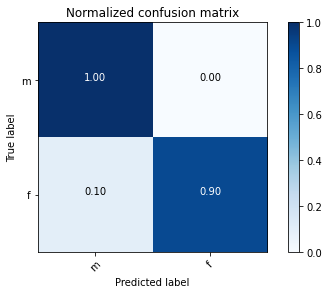

In [ ]:
cm = confusion_matrix(real_labels, pred_labels)
np.set_printoptions(precision=2)
classes = ["m","f"]
plt.figure()
plot_confusion_matrix(cm, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

For an even better evaluation, It’s always recommended to use the precision and recall metrics for the classification problem. sklearn made it easy for us to have a detailed report about the precision and recall of our multiclass classification. We just need to provide the real and predicted values and our classes names.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(real_labels, pred_labels, target_names=classes))

              precision    recall  f1-score   support

           m       0.91      1.00      0.95        20
           f       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

